
# Пример SARIMAX для TL Sales

In [2]:
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from decimal import Decimal
%matplotlib inline

In [3]:
# stat packages
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf # функция расчёта автокорреляций
from statsmodels.graphics.tsaplots import plot_acf # визуализация автокорреляций
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

In [4]:
import seaborn as sns 
sns.set_style("whitegrid")
import altair as alt # пакет визуализации Altair
alt.renderers.enable('notebook')
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [5]:
from pyramid.arima import auto_arima, ARIMA as pARIMA

In [6]:
# просмотр всех CSV-файлов в текущей папке
!dir /b *.csv

altair-data-0002fb89f3a9c86709fb46f7ad98de19.csv
altair-data-0c150113757903c1f764306ab9935e5d.csv
altair-data-11a41719a553acb316c24c22e8591e92.csv
altair-data-1cb65ffe62f9f04b5a04f6bfe5999b98.csv
altair-data-20ec790f128b237d2dc3d27e332471e7.csv
altair-data-4ed04a171f2d535fe5ca5d045a858dcf.csv
altair-data-5aabad99a38e7aa86d1651c20b630f15.csv
altair-data-609d16495dcefea569797cbf937297a8.csv
altair-data-6adb7a653a000283f864760e3852a65a.csv
altair-data-6d208bb08d56bed0199865475245a27e.csv
altair-data-8b83faf6692910a0f750738ebaced499.csv
altair-data-8b84098a5963279e570a7c7055d74d5f.csv
altair-data-bc2fc5550bb38051153f64ca366ab0da.csv
altair-data-e8a863afb2759848b2625406b32a1247.csv
altair-data-ec857f5752e7a2da6a356ef869932fc7.csv
altair-data-f17cab87058a44ea4415eb3e6895634c.csv
history_test.csv
order_test.csv
TL_Sales.csv
tvf_get_order_book_snapshots 15.09.2018-01.10.2018.csv


In [7]:
# загрузка в датафрейм
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales_df = pd.read_csv("TL_Sales.csv", delimiter=";", index_col='DATE', date_parser=dateparse)
sales_df.index = pd.to_datetime(sales_df.index)

In [8]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3637 entries, 2008-01-09 to 2019-08-30
Data columns (total 3 columns):
Sales               3343 non-null float64
Forecast_2018.09    871 non-null float64
Forecast_2017.12    349 non-null float64
dtypes: float64(3)
memory usage: 113.7 KB


In [57]:
def plot_Sales(x):
    plt.rcParams['figure.figsize'] = [16, 8]
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:,.0f} M".format(int(x)/1e6)))
    ax.xaxis.set_major_locator(dates.YearLocator(1))
    ax.xaxis.set_minor_locator(dates.MonthLocator(interval=1))
    #ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
    #ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
    ax.xaxis.grid(which='major', color='gray', linewidth=0.5)
    ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)
    plt.plot(x, marker='.', color='red', linestyle='-', linewidth=2, markerfacecolor='r')
    plt.setp(ax.xaxis.get_majorticklabels(), position=(0,0.04), rotation=0, ha="left")    
    plt.show()

## Группировка по месяцам

In [51]:
sales_by_month = sales_df.resample('MS').sum() # MS=business month start
sales_by_month.tail(24)

,Sales,Forecast_2018.09,Forecast_2017.12
DATE,,,
2017-09-01,"7,166,485","7,282,281",0
2017-10-01,"7,675,750","7,839,824",0
2017-11-01,"7,477,613","7,508,717",0
2017-12-01,"6,937,712","6,908,329",0
2018-01-01,"4,987,885","4,599,757","4,524,489"
2018-02-01,"5,647,906","5,597,704","5,544,823"
2018-03-01,"6,537,638","6,200,046","6,145,023"
2018-04-01,"6,485,919","7,023,300","6,885,451"
2018-05-01,"6,810,542","6,527,825","6,461,964"


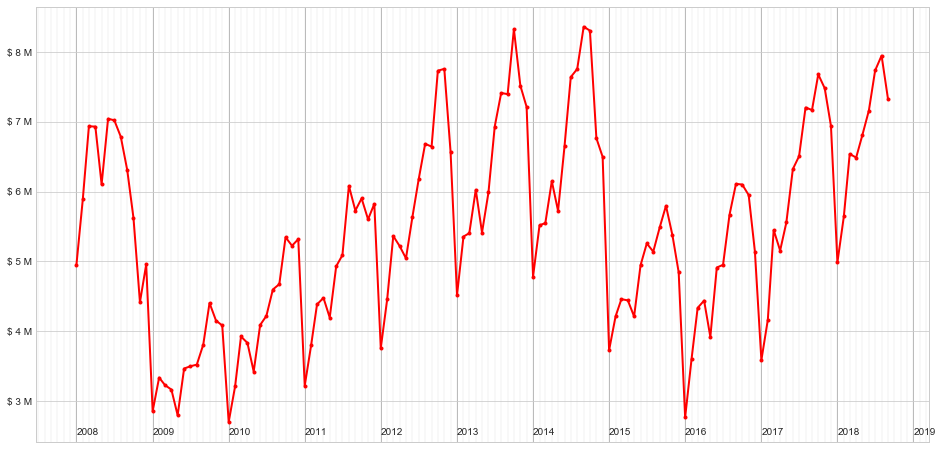

In [59]:
plot_Sales(sales_by_month.Sales['2008-01-01':'2018-09-01'])

## Графики автокорреляции

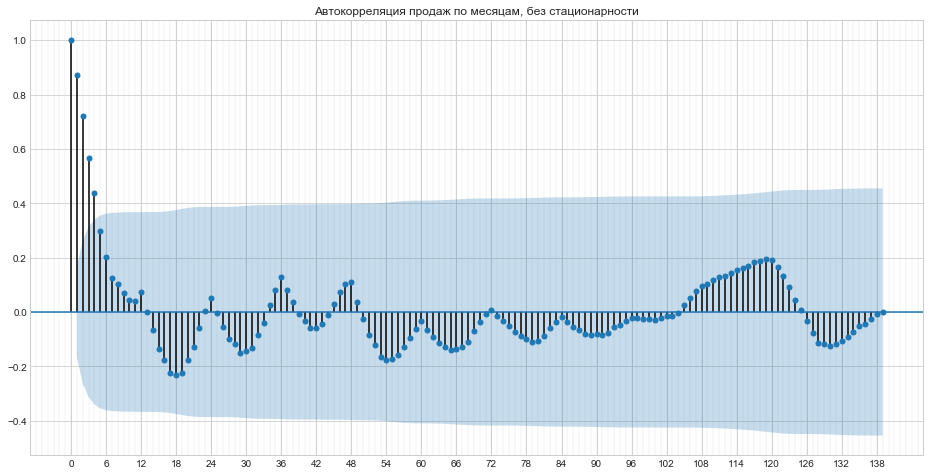

In [12]:
plt.rcParams['figure.figsize'] = [16, 8]

ax = plt.gca()
plt.xticks(np.arange(0, len(sales_by_month), step=6))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)

_ = plot_acf(sales_by_month.Sales, 
             title="Автокорреляция продаж по месяцам, без стационарности", 
             alpha=0.05, ax=ax)

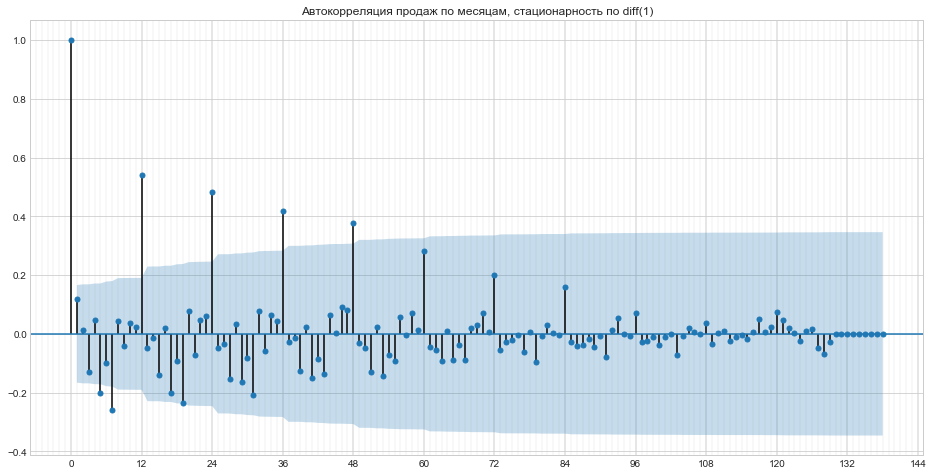

In [13]:
plt.rcParams['figure.figsize'] = [16, 8]
ax = plt.gca()
plt.xticks(np.arange(0, len(sales_by_month), step=6))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(12))
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)
ax.xaxis.grid(which='major', color='gray', linewidth=0.3)

_ = plot_acf(sales_by_month.Sales.diff().dropna(), 
             title="Автокорреляция продаж по месяцам, стационарность по diff(1)", 
             alpha=0.05, ax=ax)

На графике видны годовые корреляции, которые отмечены линиями каждые 12 интервалов

## Расчёт значений автокорреляций

In [14]:
autocorrelation = sales_by_month.Sales.autocorr(lag=1)
confidence = 1.96 / np.sqrt(len(sales_by_month))
print(f"Автокорреляция между соседними месяцами = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция между соседними месяцами = 89.45%
Приблизительный доверительный интервал = +/- 0.1657


Делаю pct_change с лагом 12, который был обнаружен на предыдущем графике

In [15]:
autocorrelation = sales_by_month.Sales.pct_change(12).autocorr()
confidence = 1.96 / np.sqrt(len(sales_by_month.pct_change(12)))
print(f"Автокорр. pct_change(12) между аналогичными периодами разных годов = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорр. pct_change(12) между аналогичными периодами разных годов = 95.49%
Приблизительный доверительный интервал = +/- 0.1657


Автокорреляция 95.34%, что даже больше, чем на соседних значениях с лагом 1

## Разбивка на train/test

In [16]:
df = sales_by_month.Sales
start_date, split_date, end_date = '2014-12-01', '2017-10-01', '2018-09-01'
#start_date, split_date, end_date = '2011-12-01', '2017-11-01', '2018-09-01'
starting = len(df[:start_date]) 
split_point = len(df[:split_date]) # 7 лет
ending = len(df[:end_date]) 
print(f"starting period={starting}, split point={split_point}, ending period={ending}")

starting period=84, split point=118, ending period=129


In [17]:
train = df.iloc[starting:split_point]
test = df.iloc[split_point-1:ending]

In [18]:
print(f"Исходный размер={len(df)}rows, train={len(train)}rows, test={len(test)}rows")

Исходный размер=140rows, train=34rows, test=12rows


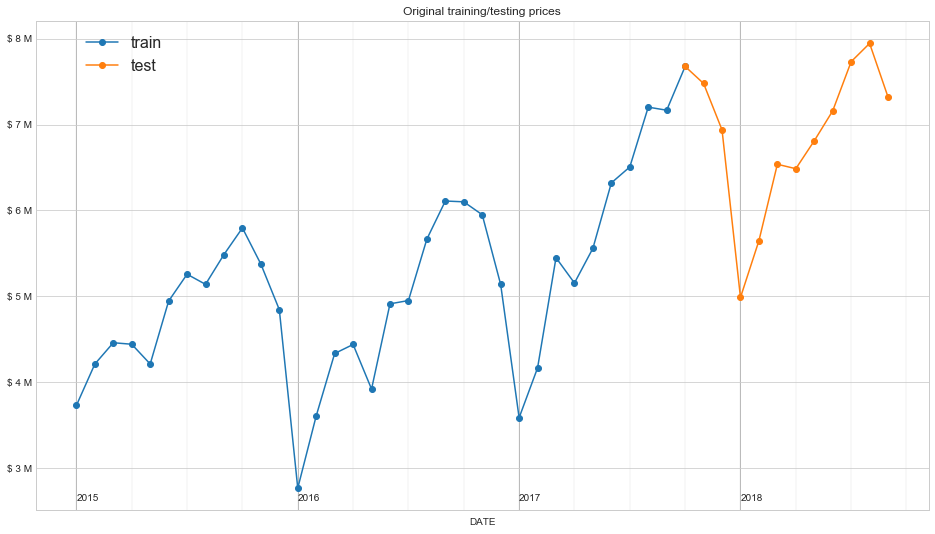

In [19]:
plt.rcParams['figure.figsize'] = [16, 9]
fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:,.0f} M".format(int(x)/1e6)))
ax.xaxis.set_major_locator(dates.YearLocator(1))
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(which='major', color='gray', linewidth=0.5)
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)

train.plot(ax=ax, marker='o', title="Original training/testing prices")
test.plot(ax=ax, marker='o')

plt.setp(ax.xaxis.get_majorticklabels(), position=(0,0.04), rotation=0, ha="left")

ax.legend(['train', 'test'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))

#plt.tight_layout()
plt.show()

## Pyramid Auto-ARIMA

In [62]:
fit = auto_arima(train, start_p=1, start_q=0, max_p=3, max_q=3, m=12,
                 start_P=1, seasonal=True, d=0, D=1, trace=True,
                 stationarity=True, 
                 out_of_sample_size=0, #len(test),
                 error_action='ignore',  # don't want to know if an order does not work
                 suppress_warnings=True,  # don't want convergence warnings
                 stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=660.827, BIC=663.009, Fit time=0.008 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=698.385, BIC=702.749, Fit time=0.114 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=657.521, BIC=660.794, Fit time=0.086 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=652.938, BIC=657.302, Fit time=0.084 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 1, 0, 12); AIC=632.951, BIC=639.497, Fit time=0.212 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 0, 12); AIC=663.174, BIC=668.629, Fit

In [63]:
print(fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   34
Model:             SARIMAX(2, 0, 2)x(1, 1, 0, 12)   Log Likelihood                -306.571
Date:                            Tue, 16 Oct 2018   AIC                            627.141
Time:                                    03:22:20   BIC                            634.779
Sample:                                         0   HQIC                           628.941
                                             - 34                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.079e+05   5.85e-06   5.26e+10      0.000    3.08e+05    3.08e+05
ar.L1         -0.0388      0.255   

In [80]:
# делаем предсказания на 24 мес вперёд
forecast_horizon = 26
predictions = fit.predict(n_periods=forecast_horizon)
#predictions = fit.predict(start='2017-11-01', end='2020-01-01')

prediction_range = pd.date_range(start=test.index[1], periods=forecast_horizon, freq='MS')

# строим прогноз
forecast = pd.DataFrame(list(zip(prediction_range, predictions)), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']

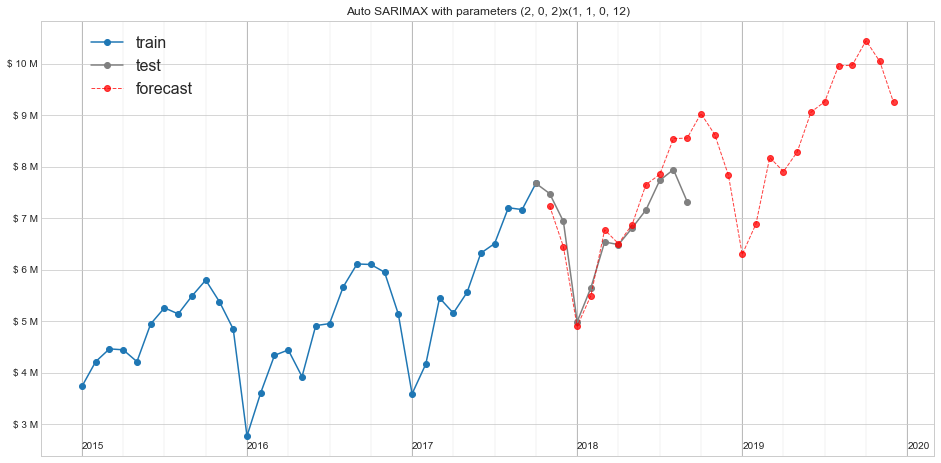

In [81]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:,.0f} M".format(int(x)/1e6)))
ax.xaxis.set_major_locator(dates.YearLocator(1))
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(which='major', color='gray', linewidth=0.5)
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)

train.plot(ax=ax, marker='o', title=f"Auto SARIMAX with parameters {fit.order}x{fit.seasonal_order}")
test.plot(color='gray', ax=ax, marker='o')
forecast.plot(color='red', linewidth=1, linestyle='--', marker='o', alpha=0.75, ax=ax)

plt.setp(ax.xaxis.get_majorticklabels(), position=(0,0.04), rotation=0, ha="left")
ax.legend(['train', 'test', 'forecast'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))
ax.set(xlabel='')
plt.show()

In [38]:
pd.options.display.float_format = '${:,.0f}'.format
pd.DataFrame({'auto SARIMAX':forecast, 
              'F2018.09':sales_by_month['Forecast_2018.09'], 
              'F2017.12':sales_by_month['Forecast_2017.12'], 
              'actual':test}).tail(22)

,auto SARIMAX,F2018.09,F2017.12,actual
2018-03-01,"$6,773,953","$6,200,046","$6,145,023","$6,537,638"
2018-04-01,"$6,504,966","$7,023,300","$6,885,451","$6,485,919"
2018-05-01,"$6,875,926","$6,527,825","$6,461,964","$6,810,542"
2018-06-01,"$7,651,005","$7,240,122","$7,212,576","$7,159,044"
2018-07-01,"$7,847,868","$8,016,000","$7,872,610","$7,731,422"
2018-08-01,"$8,543,863","$8,659,671","$8,725,595","$7,943,970"
2018-09-01,"$8,555,466","$7,753,989","$8,495,743","$7,319,573"
2018-10-01,"$9,030,585","$9,033,150","$9,700,010",$nan
2018-11-01,"$8,623,814","$8,357,325","$8,978,677",$nan
2018-12-01,"$7,830,624","$7,774,521","$967,082",$nan


## StatModels manual SARIMAX

In [39]:
pd.options.display.float_format = '{:,.0f}'.format

In [40]:
# SARIMAX model init
p,d,q = 2,0,1
seasonal_order = (1,0,0,12)

sarimax = SARIMAX(train, order=(p,d,q), trend='c',
                seasonal_order=seasonal_order, mle_regression=True,
                enforce_stationarity=False, enforce_invertibility=False).fit()
print(sarimax.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   34
Model:             SARIMAX(2, 0, 1)x(1, 0, 0, 12)   Log Likelihood                -289.942
Date:                            Tue, 16 Oct 2018   AIC                            591.885
Time:                                    03:11:08   BIC                            597.859
Sample:                                01-01-2015   HQIC                           593.051
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.067e+06   1.89e+06      0.565      0.572   -2.64e+06    4.77e+06
ar.L1         -0.0575      1.781   

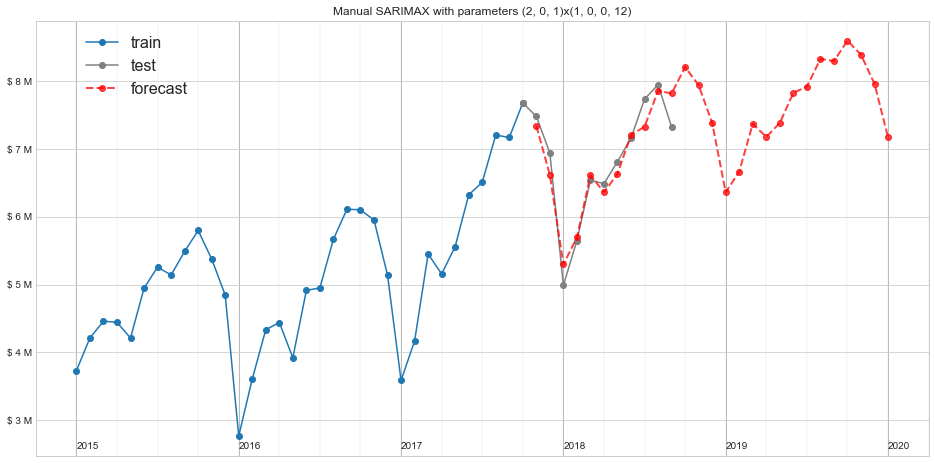

In [43]:
# делаем предсказания
# forecast_horizon = 27
sarimax_forecast = sarimax.predict(start='2017-11-01', end='2020-01-01')

plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:,.0f} M".format(int(x)/1e6)))
ax.xaxis.set_major_locator(dates.YearLocator(1))
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(which='major', color='gray', linewidth=0.5)
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)

train.plot(ax=ax, marker='o', title=f"Manual SARIMAX with parameters {p,d,q}x{seasonal_order}")
test.plot(color='gray', ax=ax, marker='o')
sarimax_forecast.plot(color='red', linewidth=2, linestyle='--', marker='o', alpha=0.75, ax=ax)

plt.setp(ax.xaxis.get_majorticklabels(), position=(0,0.04), rotation=0, ha="left")
ax.legend(['train', 'test', 'forecast'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))
ax.set(xlabel='')
plt.show()

In [44]:
pd.options.display.float_format = '{:,.0f}'.format
comparison = pd.DataFrame({'manual SARIMAX':sarimax_forecast, 
              'F2018.09':sales_by_month['Forecast_2018.09'], 
              'F2017.12':sales_by_month['Forecast_2017.12'], 
              'actual':test}).tail(27)
comparison['F2018.09 deltas'] = comparison['F2018.09'] - comparison.actual
comparison['F2017.12 deltas'] = comparison['F2017.12'] - comparison.actual
comparison['manual SARIMAX deltas'] = comparison['manual SARIMAX'] - comparison.actual

In [45]:
comparison

,manual SARIMAX,F2018.09,F2017.12,actual,F2018.09 deltas,F2017.12 deltas,manual SARIMAX deltas
2017-11-01,"7,336,725","7,508,717",0,"7,477,613","31,103","-7,477,613","-140,889"
2017-12-01,"6,616,413","6,908,329",0,"6,937,712","-29,382","-6,937,712","-321,299"
2018-01-01,"5,296,370","4,599,757","4,524,489","4,987,885","-388,128","-463,396","308,484"
2018-02-01,"5,693,977","5,597,704","5,544,823","5,647,906","-50,202","-103,084","46,071"
2018-03-01,"6,611,152","6,200,046","6,145,023","6,537,638","-337,592","-392,614","73,514"
2018-04-01,"6,359,735","7,023,300","6,885,451","6,485,919","537,381","399,532","-126,184"
2018-05-01,"6,630,592","6,527,825","6,461,964","6,810,542","-282,717","-348,578","-179,950"
2018-06-01,"7,204,869","7,240,122","7,212,576","7,159,044","81,078","53,532","45,825"
2018-07-01,"7,324,644","8,016,000","7,872,610","7,731,422","284,578","141,188","-406,777"
2018-08-01,"7,855,044","8,659,671","8,725,595","7,943,970","715,701","781,625","-88,926"
